In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.patches import Polygon
from matplotlib.cm import ScalarMappable
from matplotlib.colorbar import ColorbarBase

In [2]:
states = pd.read_csv("states.csv")
states.head()

,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
0,Alabama,1992,NaN,2678885,304177,1659028,715680,2653798,1481703,735036,NaN,174053
1,Alaska,1992,NaN,1049591,106780,720711,222100,972488,498362,350902,NaN,37451
2,Arizona,1992,NaN,3258079,297888,1369815,1590376,3401580,1435908,1007732,NaN,609114
3,Arkansas,1992,NaN,1711959,178571,958785,574603,1743022,964323,483488,NaN,145212
4,California,1992,NaN,26260025,2072470,16546514,7641041,27138832,14358922,8520926,NaN,2044688


In [3]:
#Missing values
states.isna().sum()

STATE                            0
YEAR                             0
ENROLL                          51
TOTAL_REVENUE                    0
FEDERAL_REVENUE                  0
STATE_REVENUE                    0
LOCAL_REVENUE                    0
TOTAL_EXPENDITURE                0
INSTRUCTION_EXPENDITURE          0
SUPPORT_SERVICES_EXPENDITURE     0
OTHER_EXPENDITURE               51
CAPITAL_OUTLAY_EXPENDITURE       0
dtype: int64

## How have revenues and expenditures changed over time?
***

In [4]:
# State List
states_list = states["STATE"][states["STATE"].notnull()].unique()

# Aggregate the States for General Time-Series
states_mean = (states.mean()/1000).reset_index()
states_mean.columns =["Variable","Mean"]

# Since these variables operate at a different level of magnitude, split them.
highmag = list(states_mean["Variable"][(states_mean["Mean"] > 2000) & (states_mean["Variable"] != "YEAR")])
lowmag = [x for x in list(states_mean["Variable"][states_mean["Variable"] != "YEAR"]) if x not in highmag]
print("High Magnitude Variables:\n",highmag)
print("\nLow Magnitude Variables:\n",lowmag)

High Magnitude Variables:
 ['TOTAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE']

Low Magnitude Variables:
 ['ENROLL', 'FEDERAL_REVENUE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']


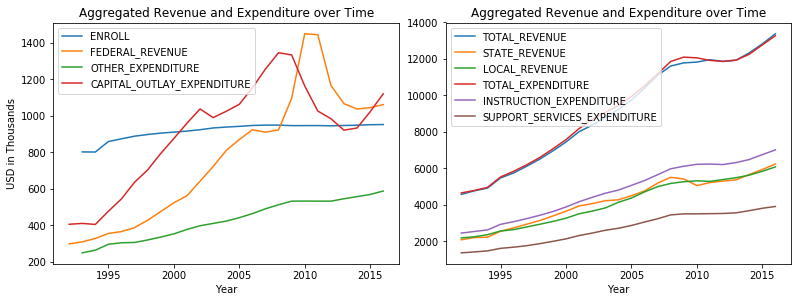

In [5]:
f, ax = plt.subplots(1,2, figsize=[11,4])
for i,x in enumerate([lowmag,highmag]):
    (states[x+["YEAR"]].groupby(["YEAR"]).mean()/1000).plot(ax=ax[i])
    #ax[i].legend(fontsize='large', loc='center left',bbox_to_anchor=(1, 0.5))
    ax[i].set_title("Aggregated Revenue and Expenditure over Time")
    ax[i].set_xlabel("Year")
ax[0].set_ylabel("USD in Thousands")
plt.tight_layout(pad=0)
plt.show()

## Volatility over time
***

In [34]:
# State/Year Aggregator
def aggr_year_state(df, var, n=7):
    temp = (df[[var,"YEAR","STATE"]].groupby(["YEAR", "STATE"]).mean()/1000).reset_index().set_index("YEAR")
    temp = temp[temp.notnull()]
    volatile = temp.groupby("STATE").std().sort_values(by=var, ascending=False).reset_index().loc[:n,"STATE"]
    return temp, volatile

# Volatility Plot
def volatile_subplots(df, variables):
    f, ax = plt.subplots(len(variables), figsize=[10,9], sharex=False)
    for i,var in enumerate(variables):
        temp, volatile= aggr_year_state(df,var)
        for state in volatile:
            ax[i].plot(temp[var][temp["STATE"] == state].diff(), label=state)
        ax[i].legend(fontsize='large', loc='center left',bbox_to_anchor=(1, 0.5))
        ax[i].set_title("Yearly Difference for {} - Top 7 Volatile States".format(var))

        ax[i].set_ylabel("Difference in Thousands USD")
    ax[len(variables)-1].set_xlabel("Year")
    plt.tight_layout(pad=5)

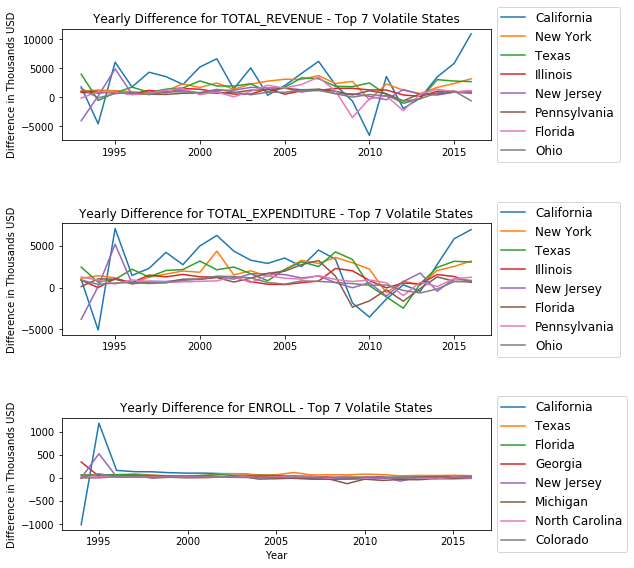

In [35]:
volatile_subplots(df=states, variables= ["TOTAL_REVENUE", "TOTAL_EXPENDITURE", "ENROLL"])
plt.show()

## Gap between Revenue and Expenditure
***

C:\Users\cschu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


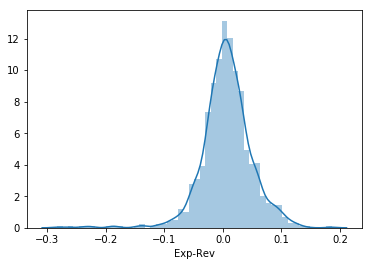

In [8]:
#gap metric normalized
states["Exp-Rev"] = (states["TOTAL_EXPENDITURE"] - states["TOTAL_REVENUE"])/states["TOTAL_REVENUE"]

sns.distplot(states["Exp-Rev"])
plt.show()

In [9]:
def state_year_plot(df, var,states):
    f, ax = plt.subplots(1, figsize=[8,5])
    for state in states:
        ax.plot(df[var][df["STATE"] == state], label=state)
    ax.legend(fontsize='large', loc='center left',bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Year")
    ax.set_ylabel("Difference Scaled by Total Revenue")
    ax.set_title("Difference Between Total Expenditure and Revenue by State")

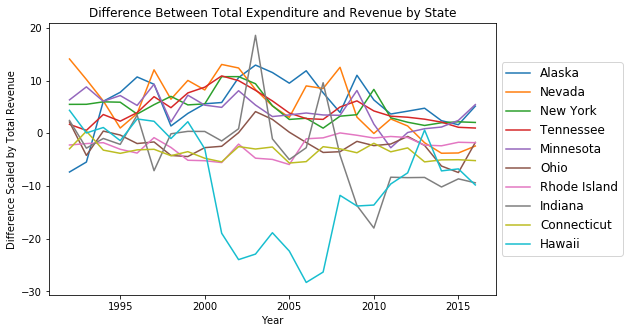

In [10]:
# New df
benefit = round(states[["Exp-Rev","YEAR","STATE"]].groupby(["YEAR","STATE"]).mean().mul(100),2).reset_index().set_index("YEAR")
# Top / Bottom States
sort_exp = benefit.groupby("STATE").mean().sort_values(by="Exp-Rev", ascending=False).reset_index()
top = list(sort_exp["STATE"].head())
bot = list(sort_exp["STATE"].tail())
# Plot
state_year_plot(df=benefit, var="Exp-Rev", states= top+bot)

## Include President By Period
***

In [11]:
states["President"] = np.nan

states.loc[states["YEAR"] <= 2000,"President"] = 'Bill Clinton'
states.loc[(states["YEAR"] > 2000) & (states["YEAR"] <= 2009),"President"] = 'George Bush'
states.loc[(states["YEAR"] > 2009),"President"] = 'Barack Obama'

print(states['President'].value_counts())

George Bush     459
Bill Clinton    459
Barack Obama    357
Name: President, dtype: int64


C:\Users\cschu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


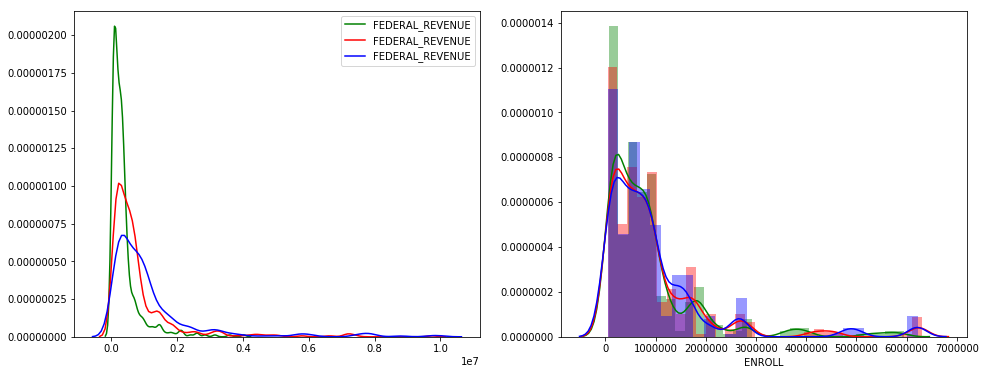

In [12]:
#Revenue distributions by president
Bill = states[states["President"] == "Bill Clinton"]
Bush = states[states["President"] == "George Bush"]
Obama = states[states["President"] == "Barack Obama"]

plt.figure(figsize = (16,6))
plt.subplot(121)
g1 = sns.kdeplot(Bill['FEDERAL_REVENUE'], color='g')
g1 = sns.kdeplot(Bush['FEDERAL_REVENUE'], color='r')
g1 = sns.kdeplot(Obama['FEDERAL_REVENUE'], color='b')

#Enrollment distributions by president
plt.subplot(122)
g1 = sns.distplot(Bill['ENROLL'].dropna(), color='g')
g1 = sns.distplot(Bush['ENROLL'].dropna(), color='r')
g1 = sns.distplot(Obama['ENROLL'].dropna(), color='b')

plt.show()

C:\Users\cschu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


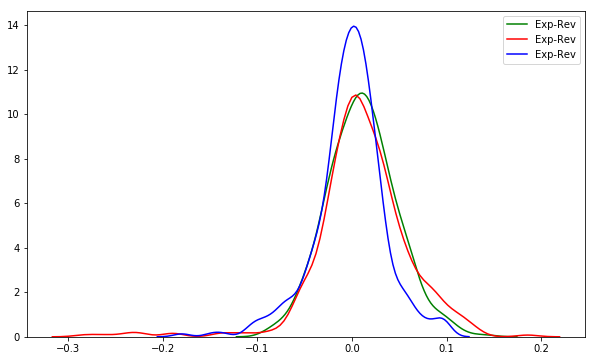

In [13]:
#Revenue gap by president
plt.figure(figsize = (10,6))
g = sns.kdeplot(Bill['Exp-Rev'], color='g')
g = sns.kdeplot(Bush['Exp-Rev'], color='r')
g = sns.kdeplot(Obama['Exp-Rev'], color='b')

In [14]:
#Revenues and expenditures on a per student basis. Not dividing revenue gap by number of students

std_states = states.copy()
std_states[std_states.columns[3:-2]] = std_states[std_states.columns[3:-2]].div(std_states['ENROLL'].values,axis=0)
std_states.tail(5)

,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,Exp-Rev,President
1270,Virginia,2016,1283493.0,12.667988,0.824427,4.906600,6.936961,12.853611,6.968962,4.023940,0.501371,0.904814,0.014653,Barack Obama
1271,Washington,2016,1083973.0,13.805108,1.012649,8.497630,4.294829,14.071657,6.538322,4.524628,0.532860,2.033315,0.019308,Barack Obama
1272,West Virginia,2016,276764.0,12.254408,1.293767,6.731591,4.229051,12.164031,6.519038,4.072983,0.854472,0.655403,-0.007375,Barack Obama
1273,Wisconsin,2016,857736.0,13.637606,0.912414,6.979727,5.745466,13.742614,6.715840,4.303701,0.592272,1.262450,0.007700,Barack Obama
1274,Wyoming,2016,94511.0,21.634191,1.301563,12.441927,7.890701,21.523727,9.750124,6.197162,0.566812,4.806869,-0.005106,Barack Obama


C:\Users\cschu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 1584x1080 with 0 Axes>

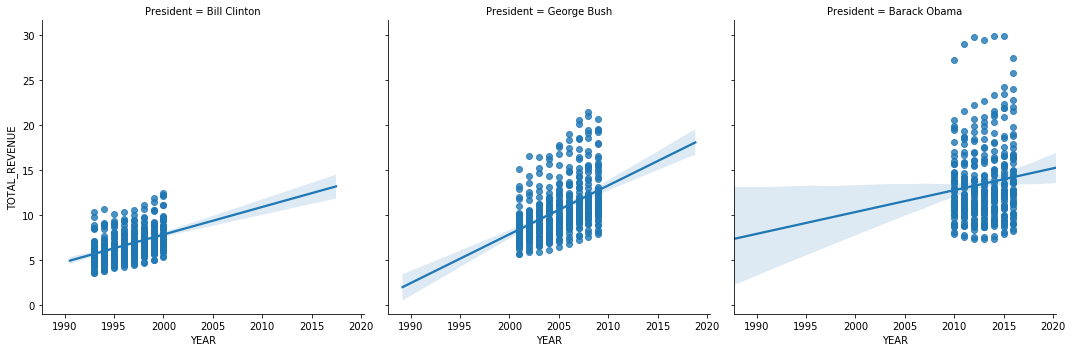

In [15]:
#Revenue per student by president era
plt.figure(figsize =( 22,15))

g = sns.lmplot(x="YEAR",y='TOTAL_REVENUE', 
           data=std_states, col="President",sharey=True)
plt.show()

C:\Users\cschu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 1584x1080 with 0 Axes>

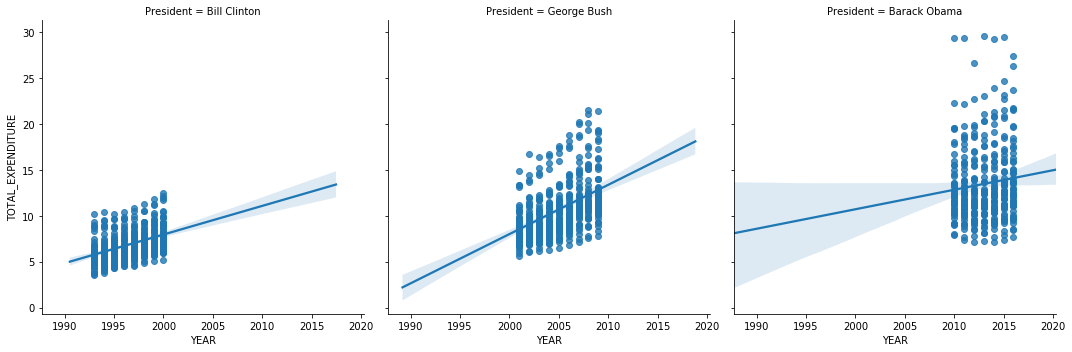

In [16]:
#Expenditure per student by president era
plt.figure(figsize =( 22,15))

g = sns.lmplot(x="YEAR",y='TOTAL_EXPENDITURE', 
           data=std_states, col="President",sharey=True)
plt.show()

## Exploring school funding for 2014 at state level
***

In [17]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

Current size: [6.0, 4.0]


In [18]:
states_2014=states.loc[states['YEAR'] == 2014]
states_2014.head()

,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,Exp-Rev,President
1122,Alabama,2014,740081.0,7357267,794090,4031547,2531630,7587737,3824295,2390530,587642.0,580934,0.031325,Barack Obama
1123,Alaska,2014,130539.0,2663647,309525,1824373,529749,2727056,1346457,982843,86314.0,269107,0.023805,Barack Obama
1124,Arizona,2014,943937.0,8361708,1102980,3182285,4076443,8109460,3902565,2858103,461316.0,678228,-0.030167,Barack Obama
1125,Arkansas,2014,479881.0,5193218,552738,4006889,633591,5242672,2609867,1753929,282078.0,424314,0.009523,Barack Obama
1126,California,2014,6224685.0,72389126,7415061,38410554,26563511,72506810,35539425,21594573,3581789.0,6124103,0.001626,Barack Obama


In [19]:
states_2014.isna().sum()

STATE                           0
YEAR                            0
ENROLL                          0
TOTAL_REVENUE                   0
FEDERAL_REVENUE                 0
STATE_REVENUE                   0
LOCAL_REVENUE                   0
TOTAL_EXPENDITURE               0
INSTRUCTION_EXPENDITURE         0
SUPPORT_SERVICES_EXPENDITURE    0
OTHER_EXPENDITURE               0
CAPITAL_OUTLAY_EXPENDITURE      0
Exp-Rev                         0
President                       0
dtype: int64

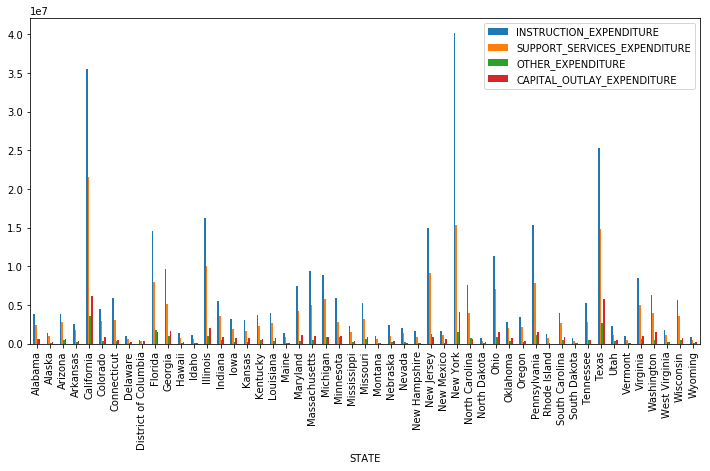

In [20]:
#Bar plot for types of expenditures
states_2014.plot(x="STATE", 
                 y=["INSTRUCTION_EXPENDITURE",
                    "SUPPORT_SERVICES_EXPENDITURE",
                    "OTHER_EXPENDITURE",
                    "CAPITAL_OUTLAY_EXPENDITURE"], 
                 kind="bar")



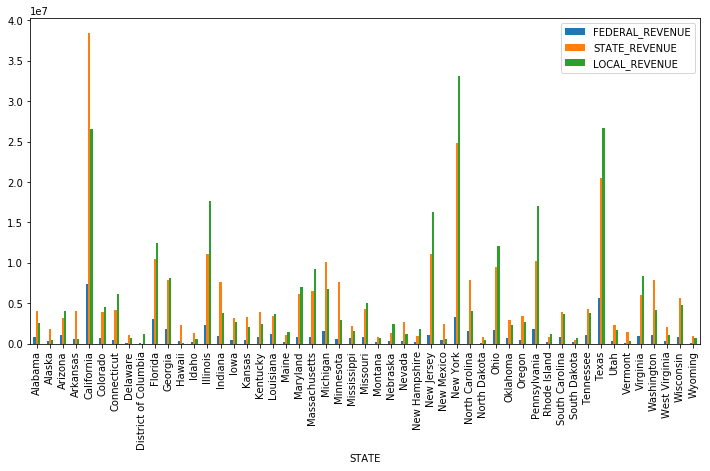

In [21]:
#Bar plot for types of revenues
states_2014.plot(x="STATE", 
                 y=["FEDERAL_REVENUE",
                    "STATE_REVENUE",
                   "LOCAL_REVENUE"], 
                 kind="bar")


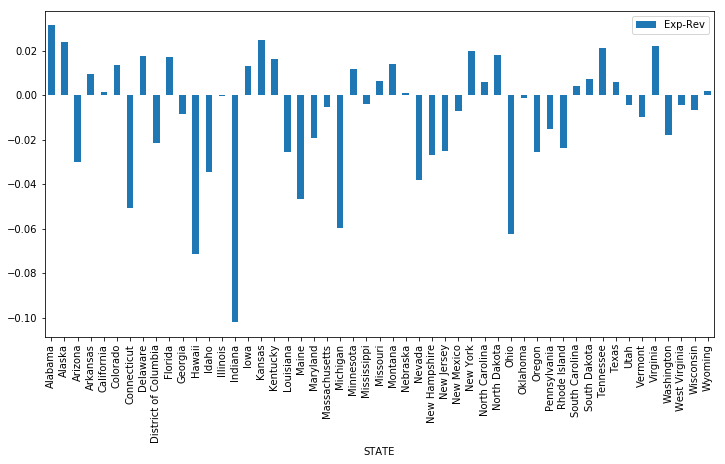

In [22]:
#Bar plot for revenue gap metric
states_2014.plot(x="STATE", 
                 y=["Exp-Rev"], 
                 kind="bar")


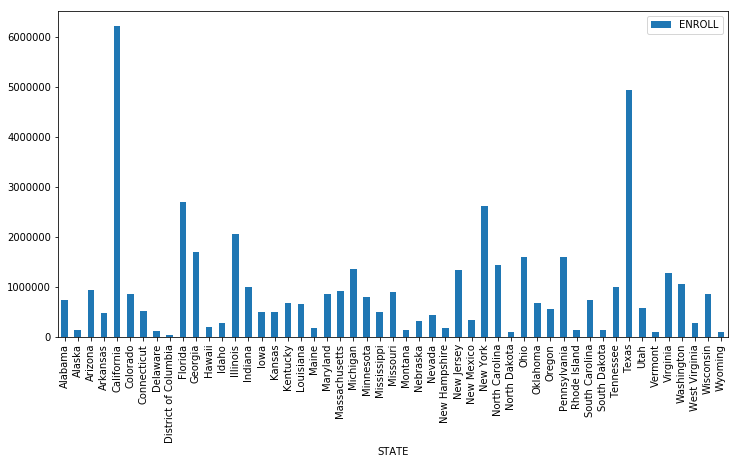

In [23]:
#Bar plot for number of enrollments
states_2014.plot(x="STATE", 
                 y=["ENROLL"], 
                 kind="bar")

In [24]:
#Revenues and expenditures on a per student basis. Not dividing revenue gap by number of students

std_states_2014 = states_2014.copy()
std_states_2014[std_states_2014.columns[3:-2]] = std_states_2014[std_states_2014.columns[3:-2]].div(std_states_2014['ENROLL'].values,axis=0)
std_states_2014.head()

,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,Exp-Rev,President
1122,Alabama,2014,740081.0,9.941165,1.072977,5.447440,3.420747,10.252576,5.167401,3.230092,0.794024,0.784960,0.031325,Barack Obama
1123,Alaska,2014,130539.0,20.404990,2.371130,13.975693,4.058167,20.890738,10.314596,7.529114,0.661212,2.061507,0.023805,Barack Obama
1124,Arizona,2014,943937.0,8.858333,1.168489,3.371290,4.318554,8.591103,4.134349,3.027854,0.488715,0.718510,-0.030167,Barack Obama
1125,Arkansas,2014,479881.0,10.821887,1.151823,8.349755,1.320309,10.924942,5.438571,3.654925,0.587808,0.884207,0.009523,Barack Obama
1126,California,2014,6224685.0,11.629364,1.191235,6.170682,4.267447,11.648270,5.709433,3.469183,0.575417,0.983841,0.001626,Barack Obama


In [25]:
std_states_2014.describe()

,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,Exp-Rev
count,51.0,5.100000e+01,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,2014.0,9.486075e+05,13.639871,1.155345,6.532905,5.951621,13.507284,7.027432,4.167565,0.602754,1.174884,-0.008605
std,0.0,1.138403e+06,4.491789,0.393555,2.794372,4.105305,4.416956,2.365574,1.315925,0.148850,1.216916,0.027581
min,2014.0,4.494200e+04,7.407906,0.675306,0.000000,0.295341,7.151671,3.939457,1.998463,0.387899,0.280544,-0.101889
25%,2014.0,2.808585e+05,10.558296,0.923863,4.698483,3.726880,10.712120,5.332588,3.288354,0.519026,0.694694,-0.024392
50%,2014.0,6.700690e+05,12.327973,1.103065,5.989266,4.958469,12.233465,6.496773,3.797016,0.575417,0.966404,-0.003801
75%,2014.0,1.032447e+06,15.671656,1.208875,7.491738,7.527186,15.652491,8.278335,4.886790,0.661179,1.173994,0.012548
max,2014.0,6.224685e+06,29.865605,3.002959,16.995715,26.862645,29.221864,15.335676,8.365582,1.094239,8.890681,0.031325


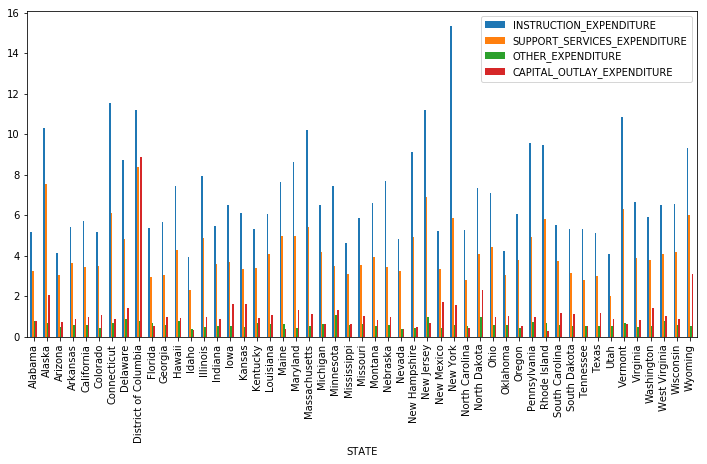

In [26]:
#Expenditure per student
std_states_2014.plot(x="STATE", 
                 y=["INSTRUCTION_EXPENDITURE",
                    "SUPPORT_SERVICES_EXPENDITURE",
                   "OTHER_EXPENDITURE",
                   "CAPITAL_OUTLAY_EXPENDITURE"], 
                 kind="bar")

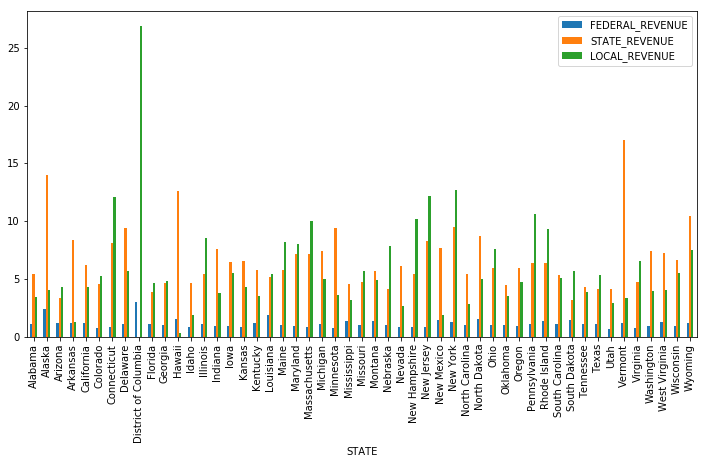

In [27]:
#Revenue per student
std_states_2014.plot(x="STATE", 
                 y=["FEDERAL_REVENUE",
                    "STATE_REVENUE",
                   "LOCAL_REVENUE"], 
                 kind="bar")


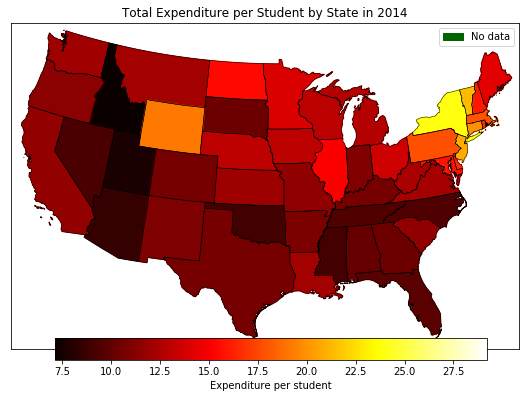

In [28]:
#Basemap heatmap of Total Expenditure bar chart

# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
ax = plt.gca() 
fig = plt.gcf()

# draw state boundaries.
# data from U.S Census Bureau
# http://www.census.gov/geo/www/cob/st2000.html
shp_info = m.readshapefile('st99_d00','states',drawbounds=True)
# Total revenue by state from std_states_2014
state_exp = pd.Series(std_states_2014['TOTAL_EXPENDITURE'].values,index=std_states_2014['STATE']).to_dict()

nodata_color = "darkgreen"
colors={}
statenames=[]
patches = []

cmap = plt.cm.hot
vmin = min(state_exp.values()); vmax = max(state_exp.values())
norm = Normalize(vmin=vmin, vmax=vmax)
# color mapper to covert values to colors
mapper = ScalarMappable(norm=norm, cmap=cmap)

for shapedict in m.states_info:
    statename = shapedict['NAME']
    if statename in state_exp:
        exp = state_exp[statename]
        colors[statename] = mapper.to_rgba(exp)
        statenames.append(statename)
    else:
        statenames.append(statename)
        colors[statename] = nodata_color

for nshape,seg in enumerate(m.states):
    color = rgb2hex(colors[statenames[nshape]]) 
    poly = Polygon(seg,facecolor=color,edgecolor=color)
    if (colors[statenames[nshape]] == nodata_color):
        p_no = poly
    ax.add_patch(poly)
plt.title('Total Expenditure per Student by State in 2014')

# put legend for no data states
if p_no is not None:
    plt.legend((p_no,), ('No data',))

# construct custom colorbar
cax = fig.add_axes([0.27, 0.1, 0.5, 0.05]) # posititon
cb = ColorbarBase(cax,cmap=cmap,norm=norm, orientation='horizontal')
cb.ax.set_xlabel('Expenditure per student')
plt.show()

